In [1]:
Expname = "BiLSTM_char_glove_layernorm"
pre_embeddings= "glove" # glove or random
rootpath = "/content/drive/MyDrive/Q2_DL/Experiments/"

!pip install seqeval

import torch
torch.manual_seed(0)
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence, pad_sequence
from torch.utils.data import Dataset, DataLoader, TensorDataset
import io
import sklearn
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
import seqeval
from seqeval.metrics import accuracy_score as seq_accuracy_score
from seqeval.metrics import classification_report as seq_classification_report
from seqeval.metrics import f1_score as seq_f1_score

if torch.cuda.is_available():  
  device = "cuda:0" 
else:  
  device = "cpu"  


from google.colab import drive
drive.mount('/content/drive')

     |████████████████████████████████| 51kB 6.6MB/s 
  Created wheel for seqeval: filename=seqeval-1.2.2-cp37-none-any.whl size=16172 sha256=2f259e7892bf829b92b42f64549082477f8fbc9ec15b7e9159a93fe80ddebc36
  Stored in directory: /root/.cache/pip/wheels/52/df/1b/45d75646c37428f7e626214704a0e35bd3cfc32eda37e59e5f
Successfully built seqeval
Mounted at /content/drive


{'padtag': 0, 'O': 1, 'B-nat': 2, 'I-geo': 3, 'I-art': 4, 'I-per': 5, 'B-per': 6, 'B-gpe': 7, 'I-gpe': 8, 'I-eve': 9, 'B-geo': 10, 'B-eve': 11, 'B-org': 12, 'I-tim': 13, 'B-tim': 14, 'I-org': 15, 'I-nat': 16, 'B-art': 17}


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1515: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)


training accuracy = 0.002725939118069592, microF1 = 0.0030547870556673377, macroF1 = 0.001168642314475648
training accuracy = 0.0013962127190112546, microF1 = 0.0015646470285125389, macroF1 = 0.0005985728927802099
training accuracy = 0.0009384380570403514, microF1 = 0.0010516480027707227, macroF1 = 0.0004023194853112886
training accuracy = 0.0007067249565365609, microF1 = 0.0007919818292470875, macroF1 = 0.0003029813407899828
training accuracy = 0.0046633599324646755, microF1 = 0.008206575528562125, macroF1 = 0.002625442755359579
training accuracy = 0.025233849549417747, microF1 = 0.04051862605182762, macroF1 = 0.012753639004128363
training accuracy = 0.06270417340363912, microF1 = 0.09012072169676245, macroF1 = 0.030175874387084627
training accuracy = 0.10003961473184919, microF1 = 0.13611696048421237, macroF1 = 0.04784704317172525
training accuracy = 0.13641209363858822, microF1 = 0.1785415858778966, macroF1 = 0.06511219999247377
training accuracy = 0.1697292118796275, microF1 = 0.21

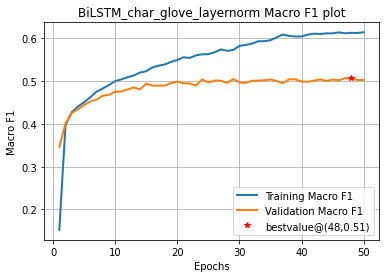

In [3]:

'''Helper Functions'''
# reading text file in python and making list of sentences (list of lists) and list of tags(list of lists)
def load_data(datapath, buildvocab_tags= True, vocab = None, nertags = None):
    if(buildvocab_tags == True):
        all_words = []
        all_tags = []
        with open(datapath) as f:
            lines = f.readlines()
            sent_num = 0
            for line in lines[1:]: #1: so that the first blank line isn't taken into account
                if(line == "\n"):
                    sent_num+=1
                else:
                    line_sep = line.split(sep = " ")
                    all_words.append(line_sep[0])
                    all_tags.append(line_sep[3][:-1])
                    
        words = list(set(all_words))
        tags = list(set(all_tags))

        vocab = {}
        vocab['<pad>'] = 0 # for padding input sequences
        vocab['<oov>'] = 1
        for i, word in enumerate(words):
            vocab[word] = i+2
            
        nertags = {}
        nertags['padtag'] = 0
        for i,nertag in enumerate(tags):
            nertags[nertag] = i+1

    train_sent = []
    train_tags = []
    with open(datapath) as f:
        lines = f.readlines()
        sent_num = 0
        sentence = []
        tag = []
        for line in lines[1:]: #1: so that the first blank line isn't taken into account
            if(line == "\n"):
                sent_num+=1
                train_sent.append(sentence)
                train_tags.append(tag)
                sentence = []
                tag = []
            else:
                line_sep = line.split(sep = " ")
                if(line_sep[0] in vocab.keys()):
                    sentence.append(vocab[line_sep[0]])
                else:
                    sentence.append(vocab['<oov>'])
                    
                tag.append(nertags[line_sep[3][:-1]])

    # padding the sentences at the end
    seq_maxlen = max(len(x) for x in train_sent)
    x_lengths = [len(x) for x in train_sent]
    Xtrain = []
    Ytrain = []
    for sent, tags in zip(train_sent, train_tags):
        length_toappend = seq_maxlen - len(sent)
        Xtrain.append(sent+[0]*length_toappend)
        Ytrain.append(tags+[0]*length_toappend)


    Xtrain = torch.Tensor(Xtrain)
    Ytrain = torch.Tensor(Ytrain)
    x_lengths = torch.Tensor(x_lengths)
    # print(Xtrain.shape, Ytrain.shape, x_lengths.shape)
    
    return Xtrain, Ytrain, x_lengths, vocab, nertags

def load_char_data(words, charvocab):
    train_char_sent = []
    train_char_label = []
    for word in words:
        chars = []
        char_labels = []

        word_sep = list(word)
        for c in word_sep[:-1]:
            if (c in charvocab.keys()):
                chars.append(charvocab[c])
            else:
                chars.append(charvocab['<oovchar>'])
        for c in word_sep[1:]:
            if (c in charvocab.keys()):
                char_labels.append(charvocab[c])
            else:
                char_labels.append(charvocab['<oovchar>'])
        
        train_char_sent.append(chars)
        train_char_label.append(char_labels)

    # padding the char_sents at the end
    seq_maxlen = max(len(x) for x in train_char_sent)
    x_lengths_char = [len(x) for x in train_char_sent]
    Xtrain_char = []
    Ytrain_char = []
    for char_sent, char_label in zip(train_char_sent, train_char_label):
        length_toappend = seq_maxlen - len(char_sent)
        Xtrain_char.append(char_sent+[0]*length_toappend)
        Ytrain_char.append(char_label+[0]*length_toappend) # 0 is padchar


    Xtrain_char = torch.Tensor(Xtrain_char)
    Ytrain_char = torch.Tensor(Ytrain_char)
    x_lengths_char = torch.Tensor(x_lengths_char)
    # print(Xtrain.shape, Ytrain.shape, x_lengths.shape)
    
    return Xtrain_char, Ytrain_char, x_lengths_char

def pad_chars(topadlist, maxlen):
    topadlist = topadlist + [0]*(maxlen-len(topadlist))

    return topadlist

def make_id2word_charvocab(vocab, charvocab):
    max_charlen = max(len(word) for word in vocab.keys())
    word_charlevel_vocab = {}
    wordid2wordlen = {}
    for word in vocab.keys():
        word_charlevel_vocab[vocab[word]] = [charvocab[w] if w in charvocab.keys() else charvocab['<oovchar>'] for w in word]
        word_charlevel_vocab[vocab[word]] = pad_chars(word_charlevel_vocab[vocab[word]], max_charlen)

        wordid2wordlen[vocab[word]] = len(word)
        # word_charlevel_vocab[vocab[word]] = word_charlevel_vocab[vocab[word]].extend([charvocab['<padchar>']]*(max_charlen-len(word_charlevel_vocab[vocab[word]])))
    return word_charlevel_vocab, wordid2wordlen


def load_char_level(X, wordid2word_charlevel_vocab, wordid2wordlen):
    #X is of shape (no.of.sentences, 104)
    Xcharlevel = [] # will finally be fo shape (total.sentences, max_sent.len, )
    Xcharlevel_lengths = []
    for i in range(X.shape[0]):
        sentence = []
        wordlengths = []
        for j in range(X.shape[1]):
            sentence.append(torch.tensor([wordid2word_charlevel_vocab[int(X[i, j].item())]]))
            wordlengths.append(wordid2wordlen[int(X[i, j].item())])
            # sentences = pad_sequence(sentences)
        # print(i)
        Xcharlevel_lengths.append(wordlengths)
        Xcharlevel.append(torch.stack(sentence))
    
    return torch.squeeze(torch.stack(Xcharlevel)), torch.tensor(Xcharlevel_lengths)

def get_charvocab(vocab):
    # using vocab make charvocab
    words = list(vocab.keys())
    characters = [char for word in words for char in word]
    characters = list(set(characters))
    char_vocab = {}
    char_vocab["<padchar>"] = 0
    char_vocab["<oovchar>"] = 1
    for i, char in enumerate(characters):
        char_vocab[char] = i+2

    return char_vocab


"""### Training Data
### using dataloader to make data batches"""

traindatapath = "/content/drive/MyDrive/Q2_DL/train.txt"
devdatapath = "/content/drive/MyDrive/Q2_DL/dev.txt"

Xtrain, Ytrain, x_trainlengths, vocab, nertags = load_data(traindatapath, buildvocab_tags=True)
Xdev, Ydev, x_devlengths, _, _ = load_data(devdatapath, buildvocab_tags=False, vocab = vocab, nertags = nertags)

# Character Level training data making
# make vocabulary of characters from train vocabulary
char_vocab = get_charvocab(vocab)
wordid2word_charlevel_vocab, wordid2wordlen = make_id2word_charvocab(vocab, char_vocab) # of the form {word:[1,2,3,4]}, {wordnum:wordlen}
#make char level train data for the char embeddings 
Xtrain_char, xlength_char = load_char_level(Xtrain, wordid2word_charlevel_vocab, wordid2wordlen)
#finally make the dataloader for train
traindataset = TensorDataset(Xtrain, Xtrain_char, Ytrain, x_trainlengths, xlength_char)
Trainloader = DataLoader(traindataset, batch_size= 128, shuffle=True)


# Character Level validation data making
Xdev_temp, Ydev_temp, x_devlengths_temp, devvocab, devnertags = load_data(devdatapath, buildvocab_tags=True)
wordid2word_charlevel_vocab_dev, wordid2wordlen_dev = make_id2word_charvocab(devvocab, char_vocab) # of the form {word:[1,2,3,4]}, {wordnum:wordlen}
#make char level train data for the char embeddings 
Xdev_char, xdevlength_char = load_char_level(Xdev_temp, wordid2word_charlevel_vocab_dev, wordid2wordlen_dev)
#finally make the dataloader for train
devdataset = TensorDataset(Xdev, Xdev_char, Ydev, x_devlengths, xdevlength_char)
Devloader = DataLoader(devdataset, batch_size= 128, shuffle=True)

# LOAD EMBEDDINGS
embedding_size = 100
if(pre_embeddings == "glove"):
    gloveembeddings_index = {}
    with io.open("/content/drive/MyDrive/Q2_DL/glove.6B.100d.txt", encoding='utf8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:],dtype='float32')
            gloveembeddings_index[word] = coefs

    #using vocab and Xtrain, Xvalid, get pretrained glove word embeddings
    glove_embeds = np.zeros((len(vocab), embedding_size))
    for word in vocab.keys():
        if(word in gloveembeddings_index.keys()):
            # for the pad word let theembedding be all zeros
            glove_embeds[vocab[word]] = gloveembeddings_index[word]
        else:
            glove_embeds[vocab[word]] = np.random.randn(embedding_size)
    word_embeds = torch.Tensor(glove_embeds)
    # print(glove_embeds.shape) # shape (vocablength , embedding dim)

if(pre_embeddings == "random"):
    num_words = len(vocab)
    word_embeds = torch.rand(num_words, embedding_size)

# hence we get word_embeds which we could use afterwards


# character level onehot embeddings and important classes for performance metrics
char_onehot = torch.eye(len(char_vocab))
imp_classes = [nertags[tag] for tag in nertags.keys()]
imp_classes.remove(nertags['padtag'])
imp_classes.remove(nertags['O'])
print(nertags)


"""# LSTM models for character **level**
"""
class forLSTM(nn.Module):
    def __init__(self, embedding_size, hidden_size, pretr_char_embed):
        super(forLSTM, self).__init__()
        self.charembed = nn.Embedding.from_pretrained(pretr_char_embed, freeze = False) #size of pretrained = (totalchars,embedding size)
        self.lstm = nn.LSTM(embedding_size, hidden_size, bidirectional = True, batch_first = True)

    def forward(self, xchar, xlength_char):
        #xchar is of shape(batchsize, seqlen_maxinbatch, maxwordlen-ie max char = 6)

        shape = xchar.shape
        xchar = xchar.view(-1, shape[2])
        xlength_char = xlength_char.view(-1)
        input = pack_padded_sequence(xchar, xlength_char.cpu(), batch_first=True, enforce_sorted=False)
        input, _ = pad_packed_sequence(input, batch_first=True)
        embed = self.charembed(input)
        _, (h,_) = self.lstm(embed) #h is of size (2, 128*maxno. of words in a sentence in the batch, 25)
        h = h.view(h.shape[1], 50)
        h = h.view(shape[0], shape[1], 50)
        return h


"""# BiLSTM Model"""
class BiLSTM(nn.Module):
    def __init__(self, embedding_size, hidden_size, total_words, num_class, pretrained = False, pretrained_embed = None, char_embed_size = 0, pretr_char_embed = None):
        super(BiLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.wordembed = nn.Embedding.from_pretrained(pretrained_embed, freeze = False)
        self.for_charembed = forLSTM(embedding_size = char_embed_size, hidden_size = 25, pretr_char_embed = pretr_char_embed)
        self.dropout = nn.Dropout(p = 0.5)
        self.bilstm = LSTM(embedding_size + 50,hidden_size, bidirectional = True, batch_first = True)
        self.linear = nn.Linear(2*hidden_size, num_class) # 2 because forward and backward concatenate

    def forward(self, x, xchar, xlengths, xlength_char):
        x = pack_padded_sequence(x, xlengths.cpu(), batch_first=True, enforce_sorted=False)
        x, _ = pad_packed_sequence(x, batch_first=True)

        xlength_char = pack_padded_sequence(xlength_char, xlengths.cpu(), batch_first=True, enforce_sorted=False)
        xlength_char, _ = pad_packed_sequence(xlength_char, batch_first=True, padding_value = len("<pad>")) 
        # above this line padding value is taken as len of pad word becasue that is what we pad sentences 
        # with hance at a character level it should be the length

        xchar = pack_padded_sequence(xchar, xlengths.cpu(), batch_first=True, enforce_sorted=False)
        xchar, _ = pad_packed_sequence(xchar, batch_first=True)

        word_embedding = self.wordembed(x) # x is of size(batchsize, seq_len), wordembed is of size (batchsize, seq_len, embedding_size = 100)
        forwardchar= self.for_charembed(xchar, xlength_char) #forwardchar and backwardchar would be of size (batchsize, seqlen. embedding_size = 25each) 
        word_embedding = torch.cat((word_embedding, forwardchar), dim = 2)

        word_embedding = self.dropout(word_embedding) #dropout
        out, (h,c) = self.bilstm(word_embedding) #'out' has dimension(batchsize, seq_len, 2*hidden_size)

        out = self.linear(out) #now 'out' has dimension(batchsize, seq_len, num_class)
        out = out.view(-1, out.shape[2]) # shape (128*seqlen, 18)
        out = F.log_softmax(out, dim=1) # take the softmax across the dimension num_class, 'out' has dimension(batchsize, seq_len, num_class)
        return out
        


model = BiLSTM(embedding_size = 100, hidden_size = 100, total_words = len(vocab), num_class = 18, pretrained = True, pretrained_embed = word_embeds, char_embed_size = len(char_vocab), pretr_char_embed = char_onehot).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3) 
lossfunction = nn.CrossEntropyLoss()


# print(model)
def performance(y, ypred, nertags):
    y = y.numpy()
    ypred = ypred.numpy()
    mask = (y != nertags['padtag']) * (y != nertags['O'])
    y = y*mask
    ypred = ypred*mask
    acc = ((y==ypred)*mask).sum()/mask.sum()
    microf1 = f1_score(y, ypred, labels = imp_classes, average='micro')
    macrof1 = f1_score(y, ypred, labels = imp_classes, average='macro')

    return acc, microf1, macrof1

def validate(model, loader):
    with torch.no_grad():
        validloss = 0
        acc = 0
        microf1 = 0
        macrof1 = 0
        i = 0
        for step, (X, Xchar, Y, xlen, xlen_char) in enumerate(loader):
            Y = pack_padded_sequence(Y, xlen, batch_first=True, enforce_sorted=False)
            Y, _ = pad_packed_sequence(Y, batch_first=True)
            ypred = model(X.long().to(device), Xchar.to(device), xlen.to(device), xlen_char.to(device))#.permute(0, 2, 1)
            vloss = lossfunction(ypred.to('cpu'), Y.view(-1).type(torch.LongTensor))
            validloss+=vloss.item()
            acc_, microf1_, macrof1_ = performance(Y.view(-1), torch.argmax(ypred.to('cpu'), dim = 1), nertags)
            acc+=acc_
            microf1 += microf1_
            macrof1 += macrof1_
            i+=1

    return validloss/i, acc/i, microf1/i, macrof1/i


trainlosslist = []
trainacclist = [] #accuracy except pad, O
trainmicrof1list = []
trainmacrof1list = []


validlosslist = []
valacclist = []
valmicrof1list = []
valmacrof1list = []


# Model is ready now we have to train using cross entropy loss
num_epochs = 50
# validloss = []
model.train()
for epoch in range(num_epochs):
    if(epoch == 35):
        optimizer = torch.optim.Adam(model.parameters(), lr = 0.0001)
    
    totalloss, acc, microf1, macrof1 = 0, 0, 0, 0
    for step, (Xbatch , Xchar ,Ybatch, xbatch_len, xlength_char) in enumerate(Trainloader):
        #make gradients 0
        optimizer.zero_grad()

        Ybatch = pack_padded_sequence(Ybatch, xbatch_len, batch_first=True, enforce_sorted=False)
        Ybatch, y_lengths = pad_packed_sequence(Ybatch, batch_first=True)

        #get output from model and claculate loss
        ypred = model(Xbatch.long().to(device), Xchar.to(device), xbatch_len.to(device), xlength_char.to(device))#.permute(0, 2, 1)
        acc_, microf1_, macrof1_ = performance(Ybatch.view(-1), torch.argmax(ypred.to('cpu'), dim = 1), nertags)
        acc+= acc_
        microf1+=microf1_
        macrof1+=macrof1_
        if(step%20 == 0 and step !=0):
            print("training accuracy = {}, microF1 = {}, macroF1 = {}".format(acc/(step+1), microf1/(step+1), macrof1/(step+1)))
        
        loss = lossfunction(ypred.to('cpu'), Ybatch.view(-1).type(torch.LongTensor)) #Ybatch has dimension (batchsize, seqlen), ypred has dimension(batchsize, num_classes, seqlen)
        totalloss += loss.item()

        #backward and step
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), 5) # clip gradient to 5
        optimizer.step()
    
    trainlosslist.append(totalloss/(step+1))
    trainacclist.append(acc/(step+1))
    trainmicrof1list.append(microf1/(step+1))
    trainmacrof1list.append(macrof1/(step+1))

    # model validation loss and scheduler step for learning rate change if required
    val_loss, val_acc, val_microf1, val_macrof1  = validate(model, Devloader)
    validlosslist.append(val_loss)
    valacclist.append(val_acc)
    valmicrof1list.append(val_microf1)
    valmacrof1list.append(val_macrof1)
    
    # scheduler.step(val_loss)
    print('\nepoch = {}, training_loss = {}, validation_loss ={}, training_acc = {}, validation_acc ={}'.format(epoch, trainlosslist[-1], validlosslist[-1], trainacclist[-1], valacclist[-1]))        
        

model.eval()


import os
if not os.path.exists(rootpath):
    os.mkdir(rootpath)

if not os.path.exists(rootpath+Expname):
    os.mkdir(rootpath+Expname)


def SavePlots(y1, y2, metric, rootpath, Expname):
    try:
        plt.clf()
    except Exception as e:
        pass
    """y2 should be validation"""
    epochs=np.arange(1,len(y1)+1,1)
    plt.title(Expname + " " + metric + " plot")
    plt.xlabel('Epochs')
    plt.ylabel(metric)
    plt.plot(epochs,y1,label='Training %s'%metric, linewidth = 2)
    plt.plot(epochs,y2,label='Validation %s'%metric, linewidth = 2)
    if(metric == "Loss"):
        ep=np.argmin(y2)
    elif(metric != "Loss"):
        ep =np.argmax(y2)
    plt.plot(ep+1,y2[ep],'r*',label='bestvalue@(%.i,%.2f)'%(ep+1,y2[ep]))
    plt.grid()
    plt.legend()
    plt.savefig(rootpath+Expname+"/{}".format(metric), dpi=300)

SavePlots(trainlosslist, validlosslist, "Loss", rootpath, Expname)
SavePlots(trainacclist, valacclist, "Accuracy", rootpath, Expname)
SavePlots(trainmicrof1list, valmicrof1list, "Micro F1", rootpath, Expname)
SavePlots(trainmacrof1list, valmacrof1list, "Macro F1", rootpath, Expname)

#make id2tag
id2tag = {}
for tag in nertags.keys():
    if(tag == 'padtag'):
        id2tag[nertags[tag]] = 'O' # because we dont want the model to predict 'padtag' tags
    else:
        id2tag[nertags[tag]] = tag


def final_metrics(model, loader):
    y_predicted = []
    y_true = []
    with torch.no_grad():
        for step, (X, Xchar, Y, xlen, xlen_char) in enumerate(loader):
            Y = pack_padded_sequence(Y, xlen, batch_first=True, enforce_sorted=False)
            Y, _ = pad_packed_sequence(Y, batch_first=True)
            ypred = model(X.long().to(device), Xchar.to(device), xlen.to(device), xlen_char.to(device))#.permute(0, 2, 1)
            ypred = torch.argmax(ypred.to('cpu'), dim = 1)
            ypred = ypred.view(Y.shape[0], -1)
            # print(ypred.shape)

            y_predicted.append(ypred)
            y_true.append(Y)

    y_predicted_list = []
    y_true_list = []
    for i in range(len(y_predicted)):
        for j in range(y_predicted[i].shape[0]):
            sent_pred = []
            sent_true = []
            for x in range(y_predicted[i].shape[1]):
                sent_pred.append(id2tag[int(y_predicted[i][j, x])])
                sent_true.append(id2tag[int(y_true[i][j, x])])
            y_predicted_list.append(sent_pred)
            y_true_list.append(sent_true)
    # print(y_predicted_list[0:5])
    # print(y_true_list[0:5])
    return seq_f1_score(y_true_list, y_predicted_list), seq_accuracy_score(y_true_list, y_predicted_list), seq_classification_report(y_true_list, y_predicted_list, digits = 3)
    #CONVERTING y_predicted and y_true lists into tag list
    # return y_predicted, y_true


# calculate the final metrics usign seq eval
# TRAINING DATA
loader_train = DataLoader(traindataset, batch_size= 1, shuffle=False)
train_f1_conll, train_acc_conll, train_classif_report = final_metrics(model, loader_train)

# VALIDATION DATA
loader_valid = DataLoader(devdataset, batch_size= 1, shuffle=False)
valid_f1_conll, valid_acc_conll, valid_classif_report = final_metrics(model, loader_valid)

print("PERFORMANCE ON Train DATA")
print('MicroF1 = {} '.format(train_f1_conll))
print('Accuracy = {}'.format(train_acc_conll))
print('------------Classification Report-------------')
print(train_classif_report)

print("PERFORMANCE ON Validation DATA")
print('MicroF1 = {} '.format(valid_f1_conll))
print('Accuracy = {}'.format(valid_acc_conll))
print('------------Classification Report-------------')
print(valid_classif_report)

#Test DATASET
testdatapath = "/content/drive/MyDrive/Q2_DL/test.txt"
char_vocab = get_charvocab(vocab)
Xtest, Ytest, x_testlengths, _, _ = load_data(testdatapath, buildvocab_tags=False, vocab = vocab, nertags = nertags)

Xtest_temp, Ytest_temp, x_testlengths_temp, testvocab, testnertags = load_data(testdatapath, buildvocab_tags=True)
wordid2word_charlevel_vocab_test, wordid2wordlen_test = make_id2word_charvocab(testvocab, char_vocab) # of the form {word:[1,2,3,4]}, {wordnum:wordlen}
#make char level train data for the char embeddings 
Xtest_char, xtestlength_char = load_char_level(Xtest_temp, wordid2word_charlevel_vocab_test, wordid2wordlen_test)
#finally make the dataloader for train
testdataset = TensorDataset(Xtest, Xtest_char, Ytest, x_testlengths, xtestlength_char)
loader_test = DataLoader(testdataset, batch_size= 1, shuffle=False)
test_f1_conll, test_acc_conll, test_classif_report = final_metrics(model, loader_test)



print("PERFORMANCE ON Test DATA")
print('MicroF1 = {}'.format(test_f1_conll))
print('Accuracy = {}'.format(test_acc_conll))
print('------------Classification Report-------------')
print(test_classif_report)


"""SAVING DATA"""

# save performance metrics dictionaries
# save train loss, acc, micro, macro
# save val loss, acc, micro, macro
# save model
import pickle
#train
pickle.dump(train_classif_report, open(rootpath+Expname+"/train_classif_report.dict.pickle", "wb" ))
np.save(rootpath+Expname+"/train_losslist.npy", np.asarray(trainlosslist))
np.save(rootpath+Expname+"/train_acclist.npy", np.asarray(trainacclist))
np.save(rootpath+Expname+"/train_microf1list.npy", np.asarray(trainmicrof1list))
np.save(rootpath+Expname+"/train_macrof1list.npy", np.asarray(trainmacrof1list))

#valid
pickle.dump(valid_classif_report, open(rootpath+Expname+"/valid_classif_report.dict.pickle", "wb" ))
np.save(rootpath+Expname+"/val_losslist.npy", np.asarray(validlosslist))
np.save(rootpath+Expname+"/val_acclist.npy", np.asarray(valacclist))
np.save(rootpath+Expname+"/val_microf1list.npy", np.asarray(valmicrof1list))
np.save(rootpath+Expname+"/val_macrof1list.npy", np.asarray(valmacrof1list))

#test
pickle.dump(test_classif_report, open(rootpath+Expname+"/test_classif_report.dict.pickle", "wb" ))


#Save Model
torch.save(model, rootpath+Expname+"/{}_model.pth".format(Expname))    
        

In [2]:
class LayerNorm_LSTMCell(nn.Module):
  def __init__(self, embedding_size, hidden_size, epsilon=1e-5):
    super(LayerNorm_LSTMCell, self).__init__()
    self.embedding_size=embedding_size
    self.hidden_size=hidden_size
    self.epsilon=1e-5

    self.inp2hidden = nn.Linear(embedding_size, 4*hidden_size) #since there are 4 linear transformations : i,f,g,o
    self.hidden2hidden = nn.Linear(hidden_size, 4*hidden_size) #this takes input h_t_minus_1

    # define layernorm layers : we are normalising input to input,forget,output,cell gate in "cummulative fashion"
    self.layernorm_inp2hidden = nn.LayerNorm(4*hidden_size)
    self.layernorm_hidden2hidden = nn.LayerNorm(4*hidden_size)
    self.layernorm_over_c = nn.LayerNorm(hidden_size)
   
  def forward(self, inp, h_c_prev=None): # x (batch,embedding_size), h_c (h and c at t-1) : [(batch,hidden_size)]*2
    h_prev, c_prev = h_c_prev if h_c_prev!=None else (torch.zeros((inp.shape[0],self.hidden_size)).to(device) , torch.zeros((inp.shape[0],self.hidden_size)).to(device))
    # first do the linear transformations with layernorms
    linear_transform_inp = self.layernorm_inp2hidden(self.inp2hidden(inp)) + self.layernorm_hidden2hidden(self.hidden2hidden(h_prev))

    #find the gates
    split=self.hidden_size
    i=torch.sigmoid(linear_transform_inp[:,0:split])
    f=torch.sigmoid(linear_transform_inp[:,split:2*split])
    o=torch.sigmoid(linear_transform_inp[:,2*split:3*split])
    g=torch.tanh(linear_transform_inp[:,3*split:])
    c=f*c_prev+i*g

    #apply final layer norm
    c=self.layernorm_over_c(c)
    h=o*torch.tanh(c)
    return (h,c)

class LSTM(nn.Module):
  def __init__(self, embedding_size, hidden_size, bidirectional=True, batch_first=True):
    super(LSTM, self).__init__()
    # bidirectional=True, batch_first=True : always (assumed)
    self.embedding_size=embedding_size
    self.hidden_size=hidden_size
    self.lstm_cell_fwd=LayerNorm_LSTMCell(embedding_size, hidden_size)
    self.lstm_cell_bkwd=LayerNorm_LSTMCell(embedding_size, hidden_size)

  def forward(self, inp): #inp (batch,seq_len,embedding_size)
    # iterate over seq_len in forward and backward direction (using their respective lstm cells)

    ht_fwd, ht_bkwd = [],[]
    ct_fwd, ct_bkwd = [],[]
    
    for t in range(inp.shape[1]):
      #forward lstm
      h_c_prev=(ht_fwd[t-1],ct_fwd[t-1]) if t!=0 else None
      ht,ct=self.lstm_cell_fwd(inp[:,t,:],h_c_prev)
      ht_fwd.append(ht)
      ct_fwd.append(ct)

      #backward lstm
      t_ = inp.shape[1]-t-1
      h_c_prev_ = (ht_bkwd[0],ct_bkwd[0]) if t_!=inp.shape[1]-1 else None
      ht_,ct_=self.lstm_cell_bkwd(inp[:,t_,:],h_c_prev_)
      ht_bkwd.insert(0,ht_)
      ct_bkwd.insert(0,ct_)
    
    #now stack ht and give it as out
    #also take last ht,ct of fwd lstm and first ht,ct of bkwd lstm
    #and give it as hn,cn after stacking

    ht_fwd=torch.stack(ht_fwd) #seq_len,batch,hidden_dim
    ct_fwd=torch.stack(ct_fwd) #seq_len,batch,hidden_dim
    ht_bkwd=torch.stack(ht_bkwd) #seq_len,batch,hidden_dim
    ct_bkwd=torch.stack(ct_bkwd) #seq_len,batch,hidden_dim
    out=torch.cat((ht_fwd,ht_bkwd),dim=2).permute(1,0,2) #batch,seq_len,2*hidden_dim
    
    hn=torch.stack((ht_fwd[-1],ht_bkwd[0])) #batch,hidden_dim
    cn=torch.stack((ct_fwd[-1],ct_bkwd[0])) #batch,hidden_dim
    return out,(hn,cn)